In [1]:
#This code takes the raw data file and extracts relevant information 
#When the raw data coordinates are unavaialble, it uses the FlightAware file to interpolate between the data and 
#fill in these gaps
#It takes the a combination of the relevant raw and, if necessary, FlightAware parameters and stores them in a new file
#This file will save to the same folder as your raw data and FlightAware files as a new .log file'

In [2]:
#Imports the modules we need
#Make sure you have these installed prior to running this code
from pathlib import Path
import csv
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import numpy
from pykml import parser 

In [3]:
#Folder in which the raw data and FlightAware files are stored 
#This is also where the output file (new .log file) from this code will be stored
path_output=  '/Users/Cosmic-On-Air/Paris-Santiago/3122" 

#FlightAware and raw data file inputs
#Change these to your own file names
file_log = Path(path_output+'31221006.log')
file_kml = path_output+'FlightAware_AFR406_LFPG_SCEL_20231006.kml'

#Parses through the kml FlightAware file using pykml
with open(file_kml) as f:
    doc = parser.parse(f).getroot()

#Set to "Yes" when GPS data is available and accurate, else set to "No"
#GPS data is accurate when there is an "A" next to the coordintes in the raw data file
control="No"

In [4]:

#Function to read and parse the log file and sort the data into a variety of categories including:
#device ID, datetime, count rate  and GPS coordinates
#It stores it in the variables data and data_gps.

def read_logfile(file):
    data = []

    with open(str(file)) as c:
        buffer = csv.reader(c)
        for row in buffer:
            if row[0].startswith('#'):
                pass
            else:
                tmp_data = {}
                tmp_data['device_id'] = row[1][1:]
                tmp_data['datetim'] = datetime.datetime.strptime(row[2],'%Y-%m-%dT%H:%M:%SZ')
                tmp_data['cnt_1mn'] = int(row[3])
                tmp_data['cnt_5sc'] = int(row[4])
                tmp_data['cnt_tot'] = int(row[5])
                tmp_data['cnt_val'] = row[6]
                tmp_data['gps_lat'] = float(row[7][0:2]) + float(row[7][2:])/60
                if row[8] == 'S':
                    tmp_data['gps_lat'] *= -1
                tmp_data['gps_lon'] = float(row[9][0:3]) + float(row[9][3:])/60
                if row[10] == 'W':
                    tmp_data['gps_lon'] *= -1
                tmp_data['gps_alt'] = float(row[11])
                tmp_data['gps_val'] = row[12]
                tmp_data['gps_hdop'] = float(row[13])
                tmp_data['gps_extra'] = row[14] 
                data.append(tmp_data)

    data_gps = [d for d in data if d['gps_val'] == 'A']
    return data_gps, data

In [5]:
#Function to read and parse the KML file (filename_kml) containing flight data. 
#It extracts timestamps (kml_time) and corresponding coordinates (kml_place) from the KML file using XML parsing.
def read_kml(filename_kml):
    kml_time = []
    for e in doc.Document.Placemark[2].findall(".//{http://www.opengis.net/kml/2.2}when"):
        kml_time.append(datetime.datetime.strptime(e.text,"%Y-%m-%dT%H:%M:%SZ"))

    kml_place = []
    for e in doc.Document.Placemark[2].findall(".//{http://www.google.com/kml/ext/2.2}coord"):
        kml_place.append(dict(zip(['lon', 'lat', 'alt'],e.text.split(' '))))

    return kml_time,kml_place

In [6]:
#Function to interpolate flight coordinates (y0) based on timestamps (x0) from KML and timestamps (x1) from the log file data. 
#It returns interpolated values (y1) for latitude, longitude, and altitude.
def interpol(y0, x0, x1):
    y1 = []
    ix0 = 0
    for i in range(len(x1)):
        if x1[i] < x0[0]:
            y1.append(y0[0])
        elif x1[i] > x0[-1]:
            y1.append(y0[-1])
        else:
            while x0[ix0] < x1[i]:
                ix0 += 1 
            y1.append((y0[ix0]-y0[ix0-1])/((x0[ix0]-x0[ix0-1]).total_seconds())*((x1[i]-x0[ix0-1]).total_seconds())+y0[ix0-1])
    return y1

In [7]:
#This function creates a new log file by combining the interpolated and raw data coordinates together
def write_newlog(new_file, data, kml_time, interp_lon, interp_lat, interp_alt):
    
    with open(str(new_file), 'w') as f:
        f.write("# NEW LOG\n")
        f.write("# format=1.3.6nano\n")
        f.write("# deadtime=on\n")

# Checks if the timestamp (item['datetim']) falls within the range of consecutive timestamps covered by the KML data (kml_time)
# If not, it uses interpolated coordinates (interp_lat, interp_lon, interp_alt)
# If yes, it uses the original GPS coordinates (item['gps_lat'], item['gps_lon'], item['gps_alt'])
        
        for i in range(len(data)):

            item = data[i] 
            if item['datetim'] > kml_time[0] and item['datetim'] < kml_time[-1]:
                cur_lat = interp_lat[i]
                cur_lon = interp_lon[i]
                cur_alt = interp_alt[i]
                cur_gps_val = "A"
            else:
                cur_lat = item['gps_lat']
                cur_lon = item['gps_lon']
                cur_alt = item['gps_alt']
                cur_gps_val = item['gps_val']

#Determines the direction (N, S, E, W) and formats latitude and longitude into degrees and minutes for writing to the log file
            if cur_lat > 0:
                cur_gps_lat_dir = "N"
            else: 
                cur_gps_lat_dir = "S"
                
            if cur_lon > 0:
                cur_gps_lon_dir = "E"
            else: 
                cur_gps_lon_dir = "W"
            
#Formats the data into a comma-separated string and writes it to the new log file
#The data includes device ID, timestamp, radiation counts, GPS coordinates, altitude, GPS quality, and additional GPS information (gps_extra).
            f.write(",".join(["$BNRDD", 
                            "1{}".format(item['device_id']),
                            item['datetim'].strftime("%Y-%m-%dT%H:%M:%SZ"),
                            "{}".format(item['cnt_1mn']),
                            "{}".format(item['cnt_5sc']),
                            "{}".format(item['cnt_tot']),
                            item['cnt_val'],
                            "{:02f}".format(cur_lat),
                            cur_gps_lat_dir,
                            "{:03f}".format(cur_lon),
                            cur_gps_lon_dir,
                            "{:.2f}".format(cur_alt),
                            cur_gps_val,
                            "{}".format(int(item['gps_hdop'])),
                            str(item['gps_extra'])])+"\n")

In [8]:
#Function to plot the Counts per Minute vs Latitude graph
def plot_latitude(control, data, interp_lat):

    #If control is set to "Yes", it only makes use of the raw data latitudes
    if control == "Yes":
        lat = [d['gps_lat'] for d in (data)]
    #Otherwise, it uses a combination of FlightAware and raw data latitudes   
    else:
       lat = interp_lat

    #Plots the figure and labels the axes 
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.scatter(lat, [d['cnt_1mn'] for d in data], marker = '.', label="CPS-1min", color = '#FF7518')
    plt.xlabel('Latitude (degrees)', fontsize=14)
    plt.ylabel('Counts per minute', fontsize=14)
    #Titles the plot - you can change this to match your data
    plt.title('Paris to Santiago - 06/10/2023 - Detector 3122', fontsize=14)

    #Limits the y-axis so that any radiation spikes measures before take-off or after landing are not plotted
    #You can change these if you would like to 
    plt.ylim(10,1200)

    #Ensures that take-off is always plotted on the left and landing on the right
    if lat[0] > lat[-1]:
        plt.gca().invert_xaxis()


In [9]:
#Function to plot the Counts per Minute vs Longitude graph
def plot_longitude(control, data, interp_lon):
    #If control is set to "Yes", it only makes use of the raw data longitudes
    if control == "Yes":
        lon = [d['gps_lon'] for d in (data)]

    #Otherwise, it uses a combination of FlightAware and raw data longitudes       
    else:
       lon = interp_lon

    #Plots the figure and labels the axes 
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.scatter(lon, [d['cnt_1mn'] for d in data], marker = '.', label="CPS-1min", color = '#FF7518')
    plt.xlabel('Longitude (degrees)', fontsize=14)
    plt.ylabel('Counts per minute', fontsize=14)
    #Titles the plot - you can change this to match your data
    plt.title('Paris to Santiago - 06/10/2023 - Detector 3122', fontsize=14)

    #Limits the y-axis so that any radiation spikes measures before take-off or after landing are not plotted
    #You can change these if you would like to 
    plt.ylim((10,1200)) 

    #Ensures that take-off is always plotted on the left and landing on the right
    if lon[0] > lon[-1]:
        plt.gca().invert_xaxis()

In [10]:
#Function to plot the Counts per Minute vs Altitude graph
def plot_altitude(control, data, interp_alt):
    #If control is set to "Yes", it only makes use of the raw data altitudes
    if control == "Yes":
        alt = [d['gps_alt']/1000 for d in (data)]
    #Otherwise, it uses a combination of FlightAware and raw data altitudes 
    else:
       alt = [a / 1000 for a in interp_alt]

    #Plots the figure and labels the axes    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.scatter(alt, [d['cnt_1mn'] for d in data], marker = '.',label="CPS-1min", color = '#FF7518')
    plt.xlabel('Altitude (km)', fontsize=14)
    plt.ylabel('Counts per minute', fontsize=14)
    #Titles the plot - you can change this to match your data
    plt.title('Paris to Santiago - 06/10/2023 - Detector 3122', fontsize=14)
    
    #Limits the x and y axes so that any radiation spikes measures before take-off or after landing are not plotted
    #You can change these if you would like to 
    plt.xlim(1,)
    plt.ylim(0, 1200)

In [11]:
#Plots a world map and the flight path with a colour-mapped radition rate.
def plot_world(interp_lon,interp_lat,data, the_max):

    #Plots the world map
    fig = plt.figure(figsize=(25, 15))
    ax1 = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax1.stock_img()

    #Ensures that any radiation > 95% of the max radiation does not skew the colour map
    d_tmp = [d['cnt_1mn'] for d in data]
    for i in range(len(d_tmp)): 
        if d_tmp[i] >= the_max*0.95:
            d_tmp[i]=the_max*0.95

    #Plots the flight path         
    p1=plt.scatter(interp_lon, interp_lat, c=d_tmp, cmap='rainbow')
    #Ensures that the whole world map is plot
    #These limits can be changed if you would like to zoom into the flight path
    plt.xlim(-180, 180)
    plt.ylim(-90,90)
    #Titles the plot
    plt.title('Paris to Santiago - 06/10/2023 - Detector 3122', fontsize = 24) 

    #Creates a legend for the colour-map 
    cbar = plt.colorbar(p1, ax=ax1, orientation='vertical')
    cbar.set_label('Dose Rate (CPM)', labelpad=30, fontsize=22)
    cbar_ticks = [0, the_max  * 0.2, the_max  * 0.4, the_max  * 0.6, the_max  * 0.8, the_max  * 0.95]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in cbar_ticks])
    cbar.ax.tick_params(labelsize=20)



870


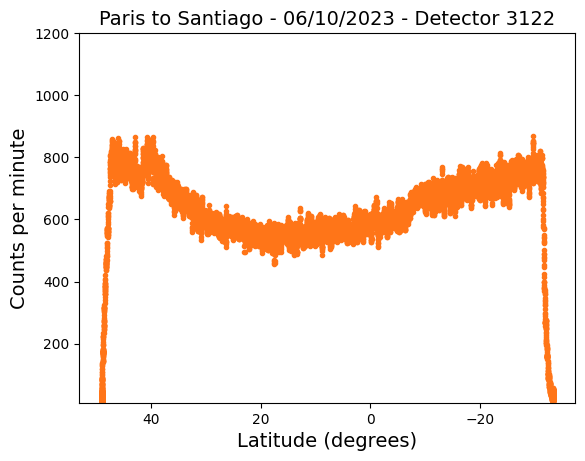

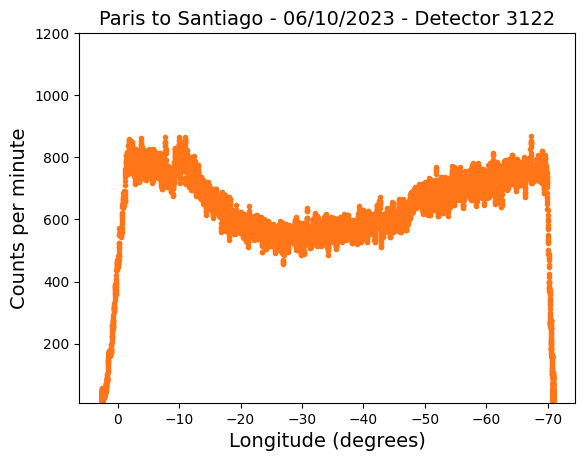

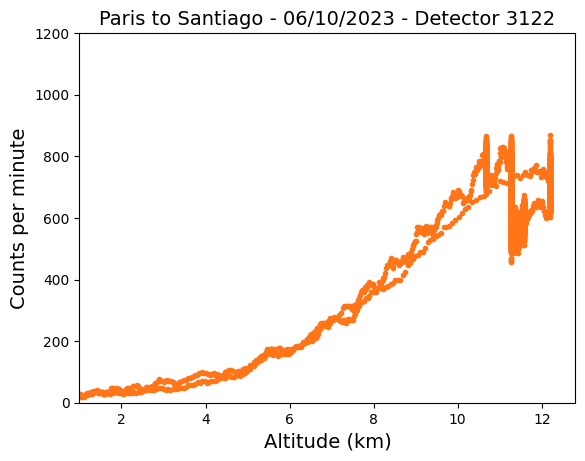

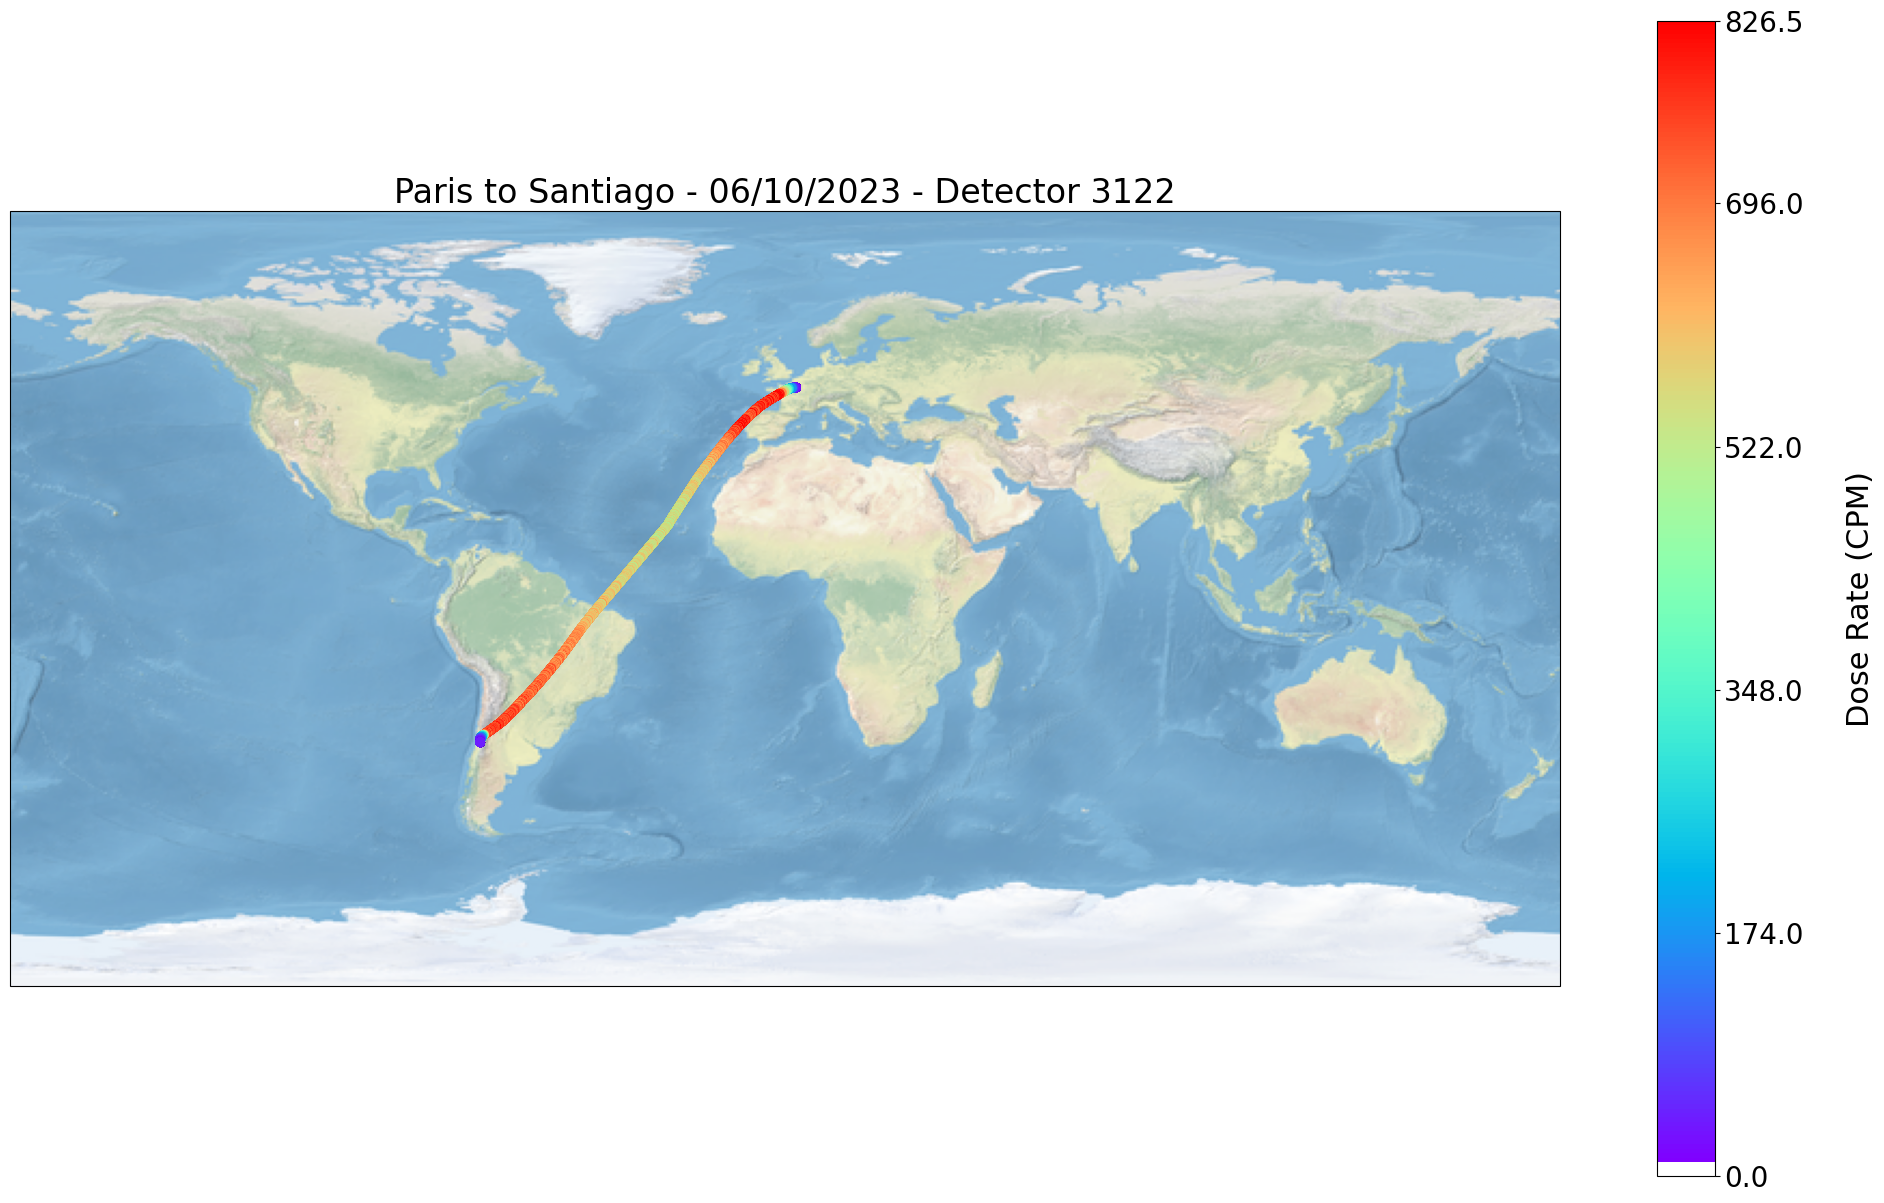

In [12]:
#This piece of the code calls all of the functions that are outlined above

#Creates the new variables data and data_gps using the raw data file 
data_gps,data = read_logfile(file_log)

#This line extracts the date (year, month, and day) from the first entry in data_gps and stores it in dt0_gps
dt0_gps = datetime.datetime(data_gps[0]['datetim'].year, data_gps[0]['datetim'].month, data_gps[0]['datetim'].day)

#Reads the FlightAware file and generates kml_time and kml_place variables for time and coordinate data respectively
kml_time,kml_place = read_kml(filename_kml=file_kml)

#Calls the interpol function to estimate the longitude (interp_lon), latitude (interp_lat), and altitude (interp_alt)
interp_lon = interpol([float(d['lon']) for d in kml_place], kml_time, [d['datetim'] for d in data])
interp_lat = interpol([float(d['lat']) for d in kml_place], kml_time, [d['datetim'] for d in data])
interp_alt = interpol([float(d['alt']) for d in kml_place], kml_time, [d['datetim'] for d in data])

#Calculates the maximum value of radiation measured in Counts per minute and prints it
the_max = max(d['cnt_1mn'] for d in data)
print(the_max)

#Calls the plot_latitude function 
plot_latitude(control, data, interp_lat)

#Calls the plot_longitude function
plot_longitude(control, data, interp_lon)

#Calls the plot_altitude function
plot_altitude(control, data, interp_alt)
              
#Calls the plot_world function
plot_world(interp_lon,interp_lat,data, the_max)

#Creates the new .log file to store all the plotted and adjusted parameters
new_file = file_log.parent / "{}-new.log".format(file_log.stem)
write_newlog(new_file, data, kml_time, interp_lon, interp_lat, interp_alt)
